# Fitting PKS 2155-304

- Do not care if fake or real data
- We do not know anything about the models used to simulate the data
- We (of course) know the observation conditions 

In [43]:
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator

In [80]:
#read the dataset
cta_dataset = MapDataset.read("pks2155-simulated.fits.gz", name="cta_dataset")

In [81]:
print(cta_dataset)

MapDataset
----------

  Name                            : cta_dataset 

  Total counts                    : 55488 
  Total background counts         : 52917.67
  Total excess counts             : 2570.33

  Predicted counts                : 52917.67
  Predicted background counts     : 52917.67
  Predicted excess counts         : nan

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




**Note:** You can convert this to a spectrum dataset and fit only the spectra...

In [121]:
src_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71693844, -30.22558846)>

In [82]:
src_pos = SkyCoord.from_name("PKS 2155-304")
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)

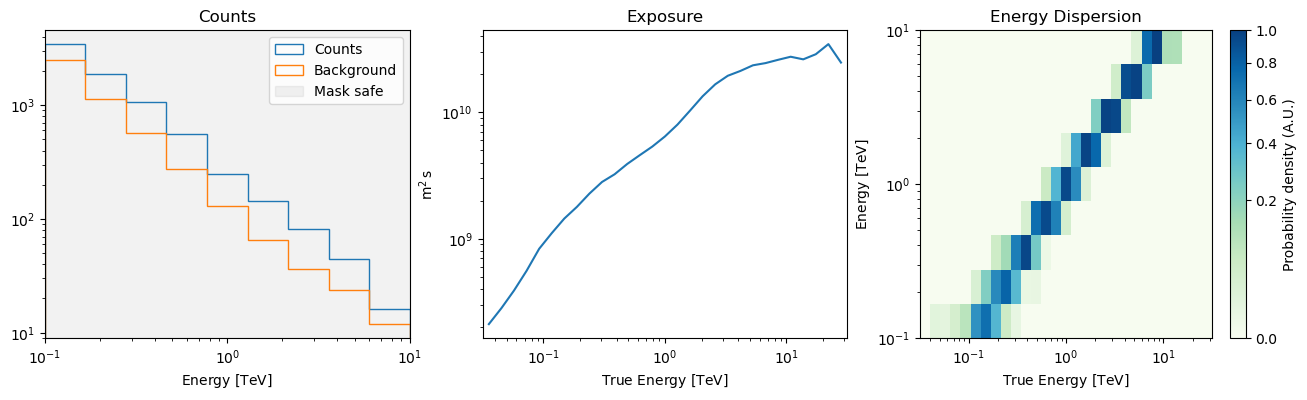

In [83]:
spectrum_dataset = cta_dataset.to_spectrum_dataset(on_region=region)
spectrum_dataset.peek()

## Data Fitting
- What is the significance of the detected source?
- Can we detect a cutoff in the observed spectrum?
- H0: Background only
- H1: Power law model
- H2: Cutoff power law

This logic can be generalised to other questions - is the source extended/variable/etc

In [105]:
#explain global Models object
models = Models()

In [106]:
## Background only
bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)
cta_dataset.models = models

In [107]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[cta_dataset])

CPU times: user 234 ms, sys: 4.27 ms, total: 239 ms
Wall time: 238 ms


In [108]:
result.success

True

In [109]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str15,str8,str9,float64,str3,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.0486e+00,,4.451e-03,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


In [110]:
L0 = result.total_stat
print(L0)

161300.11196461943


### Now, add a source model

In [111]:
spectral_model = LogParabolaSpectralModel()
spatial_model = PointSpatialModel()
pks_model = SkyModel(spectral_model=spectral_model,
                     spatial_model=spatial_model, 
                    name="pks_model")

In [112]:
spectral_model.alpha.value 

2.0

In [113]:
spectral_model.amplitude.value = 4e-12
spectral_model.alpha.value = 2.0
spectral_model.beta.value = 0.0
spectral_model.beta.frozen = True # Behaves as a power law, cutoff fixed at infty

spatial_model.lon_0.value = src_pos.ra.value
spatial_model.lat_0.value = src_pos.dec.value

In [114]:
spectral_model.alpha.value 

2.0

In [115]:
print(cta_dataset)

MapDataset
----------

  Name                            : cta_dataset 

  Total counts                    : 55488 
  Total background counts         : 52917.67
  Total excess counts             : 2570.33

  Predicted counts                : 55488.00
  Predicted background counts     : 55488.00
  Predicted excess counts         : 0.00

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 161300.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : cta_dataset-bkg
    Datasets names            : ['cta_dataset']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.049   +/-    0.0

In [116]:
models.append(pks_model)

In [117]:
cta_dataset.models = models

In [118]:
cta_dataset.models.names

['cta_dataset-bkg', 'pks_model']

In [119]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[cta_dataset])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (359.65653332, -30.22558846)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (359.65653332, -30.22558846)> is outside valid IRF map range, using nearest IRF defined within


W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_amplitude ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 2nd derivative zero for parameter par_001_amplitude ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_amplitude ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_amplitude ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_amplitude ; MnHesse fails and will r

In [120]:
result2.success

False

In [100]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.0486e+00,,nan,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,nan,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+01,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha,2.0000e+00,,nan,nan,nan,False,False,
pks_model,spectral,beta,0.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spatial,lon_0,3.2755e+02,deg,nan,nan,nan,False,False,
pks_model,spatial,lat_0,-3.0226e+01,deg,nan,-9.000e+01,9.000e+01,False,False,


In [24]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.0576e+00,,nan,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,index,2.0000e+00,,nan,nan,nan,False,False,
pks_model,spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,nan,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spatial,lon_0,3.2972e+02,deg,nan,nan,nan,False,False,


In [25]:
L1 = result2.total_stat
print("del TS of detection: ", (L0-L1), )

del TS of detection:  6.818154361099005e-07


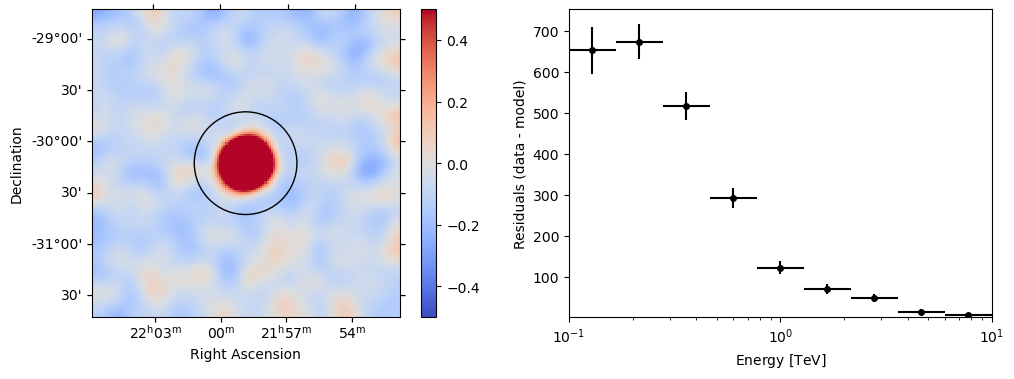

In [26]:

cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

#### Get flux points

In [27]:
energy_edges = np.logspace(-1, 1, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name)

In [28]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

CPU times: user 9.8 s, sys: 1.88 s, total: 11.7 s
Wall time: 11.7 s


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

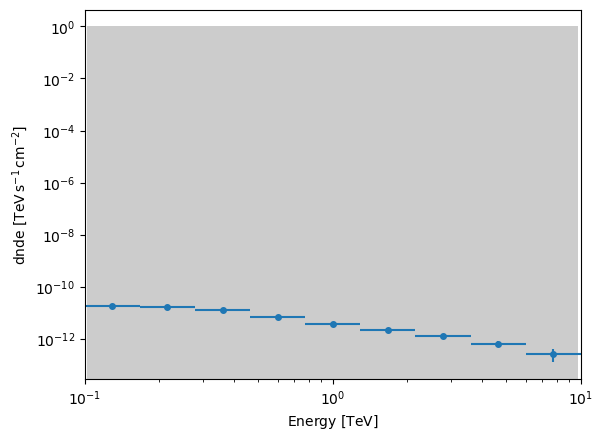

In [29]:
ax = spectral_model.plot_error(energy_bounds=[0.1,10]*u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

### Now, search for cutoff

In [30]:
spectral_model.lambda_.frozen = False

In [34]:
%%time
# fit3 = Fit(optimize_opts={"print_level": 1})
fit3 = Fit(backend='sherpa')

result3 = fit3.run(datasets=[cta_dataset])

No covariance estimate - not supported by this backend.


CPU times: user 2.99 s, sys: 106 µs, total: 2.99 s
Wall time: 2.99 s


In [35]:
result3.success

True

In [36]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.0576e+00,,nan,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,index,2.1050e+00,,nan,nan,nan,False,False,
pks_model,spectral,amplitude,1.0100e-12,TeV-1 s-1 cm-2,nan,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,lambda_,9.5907e-02,TeV-1,nan,nan,nan,False,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spatial,lon_0,3.3959e+02,deg,nan,nan,nan,False,False,


In [37]:
L2 = result3.total_stat
print("del TS of cutoff: ",(L1-L2), "p-value: ", chi2.sf((L1-L2),1))

del TS of cutoff:  7.450580596923828e-09 p-value:  0.9999311292013126


In [41]:
profile

{'pks_model.spectral.lambda__scan': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]),
 'stat_scan': array([161319.1625786, 161319.1625786, 161319.1625786, 161319.1625786,
        161319.1625786, 161319.1625786, 161319.1625786, 161319.1625786,
        161319.1625786, 161319.1625786, 161319.1625786, 161319.1625786,
        161319.1625786, 161319.1625786, 161319.1625786, 161319.1625786,
        161319.1625786]),
 'fit_results': []}

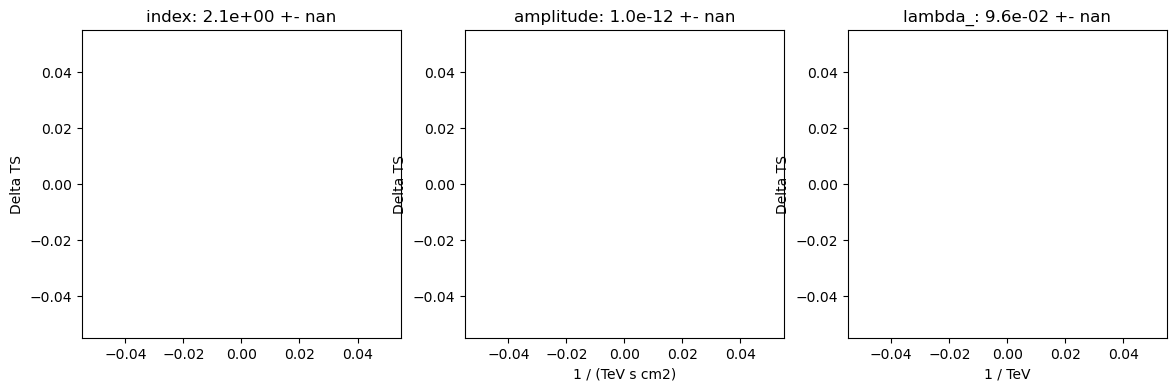

In [40]:
### See a likelihood scan of free parameters
total_stat = result3.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit3.stat_profile(datasets=[cta_dataset], parameter=par)
    ax.plot(profile[f"pks_model.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

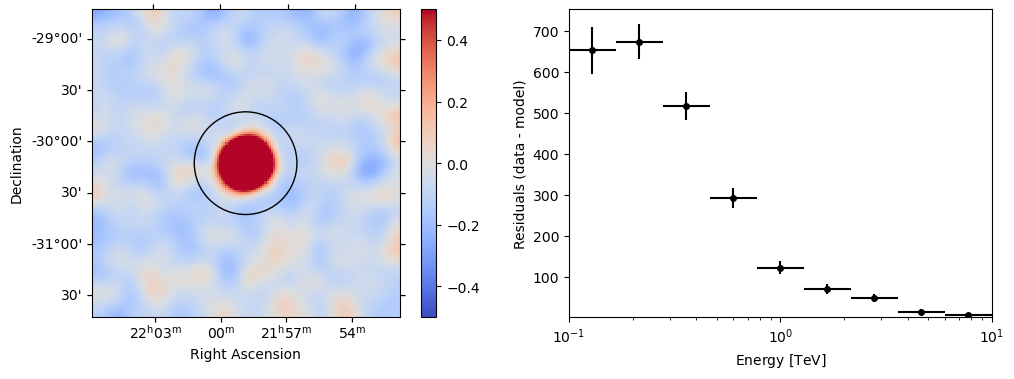

In [42]:
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

#### Get flux points

In [ ]:
energy_edges = np.logspace(-1, 1, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name)

In [ ]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

In [ ]:
ax = spectral_model.plot_error(energy_bounds=[0.1,10]*u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

We have successfully detected a cutoff in the observed spectrum.

**Exercise**: Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/0.19/modeling/gallery/index.html 
You can also try creating your own models.

## 2. Joint Flux point Fitting with Fermi-LAT

**Note:** It is also possible to fit different types of `Datasets` togther (eg: A `MapDataset` from CTA and `FluxPointDataset` from Fermi-LAT) . *Try it* 

Aim: Simulatneously fit the CTA flux points with 4FGL flux points

In [ ]:
model_copy = pks_model.copy()
spec = LogParabolaSpectralModel()
#spec = ExpCutoffPowerLawSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
model_fp = SkyModel(spec*ebl, name="model_fp")
spec.parameters["reference"].quantity = 1*u.TeV

In [ ]:
fermi_catalag = SourceCatalog4FGL()
source = fermi_catalag["PKS 2155-304"]
fermi_flux_points = source.flux_points

In [ ]:
fermi_fp_dataset = FluxPointsDataset(data=fermi_flux_points, 
                                     models=model_fp, 
                                     name="fermi")
cta_fp_dataset = FluxPointsDataset(data=flux_points, 
                                   models=model_fp, 
                                   name="cta")
datasets = Datasets([fermi_fp_dataset, cta_fp_dataset])

In [ ]:
print(datasets)

In [ ]:
%%time
fit4 = Fit(optimize_opts={"print_level": 0})
result4 = fit4.run(datasets=datasets)
result4.success

In [ ]:
model_fp.parameters.to_table()

In [ ]:
fermi_fp_dataset.plot_fit()

In [ ]:
cta_fp_dataset.plot_fit()

In [ ]:
ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde", "yunits": u.Unit("TeV cm-2 s-1")}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV
model_fp.spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
model_fp.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
spec.plot(energy_bounds=energy_bounds, color="b", **kwargs)
ax.set_ylim(5e-14, 5e-11)
plt.title("PKS 2155-304")
ax.set_xlim(energy_bounds)
ax.legend()

You can extend this
- share one EBL model among 10 blazars
- each blazar has its own intrisic model
- perform a joint fit across 10 datasets

or
- take a blazar in flare and quiescent state
- quiescent model to be shared among the two datasets
- add an extra model to the flare dataset


add your science case...

## Exercise:

 
**Note**: Pay attention to known bug for CompoundModels: https://github.com/gammapy/gammapy/discussions/3705 

- Pick your favourite SNR from the 4FGL and HGPS catalog. Do a joint fit.
Interface with a naima spectral model to directly fit the particle spectrum https://docs.gammapy.org/0.19/modeling/gallery/spectral/plot_naima.html?highlight=naima

- Convert the cta_dataset to a spectrum dataset and fit jointly with Fermi-LAT flux points